In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:

# Step 1: Data cleaning
data = yf.download(tickers='ETH-usd', start='2017-11-09', end='2022-12-31', interval='1d')
#data = yf.download(tickers='ETH-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2022-12-26,1218.920166,1226.974365,1214.335938,1226.974365,1226.974365,3282098400
2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,1212.791626,4091530737
2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,1189.986084,4991669631


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1878 entries, 2017-11-09 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1878 non-null   float64
 1   High       1878 non-null   float64
 2   Low        1878 non-null   float64
 3   Close      1878 non-null   float64
 4   Adj Close  1878 non-null   float64
 5   Volume     1878 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 102.7 KB


In [4]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace=True)
#data.drop(['Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1779 entries, 2018-02-16 to 2022-12-30
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1779 non-null   float64
 1   High       1779 non-null   float64
 2   Low        1779 non-null   float64
 3   Close      1779 non-null   float64
 4   Adj Close  1779 non-null   float64
 5   Volume     1779 non-null   int64  
 6   RSI        1779 non-null   float64
 7   EMA_short  1779 non-null   float64
 8   EMA_long   1779 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 139.0 KB


,Open,High,Low,Close,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,,
2022-12-21,1217.586426,1218.192261,1206.440063,1213.599976,1213.599976,4217182733,46.360226,1234.022934,1347.684823
2022-12-22,1213.672607,1221.986816,1187.127808,1218.182129,1218.182129,5297471739,46.932819,1232.514286,1345.120413
2022-12-23,1218.079346,1226.998779,1215.994873,1220.159424,1220.159424,4835831923,47.193442,1231.337632,1342.645938
2022-12-24,1220.117920,1224.911621,1216.338745,1221.148560,1221.148560,2626153345,47.332079,1230.367245,1340.240050
2022-12-25,1221.171509,1223.517822,1203.719604,1218.962036,1218.962036,3942720070,47.039585,1229.281034,1337.838505
2022-12-26,1218.920166,1226.974365,1214.335938,1226.974365,1226.974365,3282098400,48.294081,1229.061351,1335.643175
2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,1212.791626,4091530737,46.217774,1227.511854,1333.210471
2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,1189.986084,4991669631,43.030513,1223.937971,1330.374345
2022-12-29,1190.010132,1204.141602,1188.360229,1201.595337,1201.595337,4132233940,45.095621,1221.810101,1327.824266


In [5]:
data= data.to_csv('ETH_case1.csv')

In [2]:
data_csv = pd.read_csv('ETH_case1.csv')
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv.dropna(inplace=True)
data_csv.info()
data_csv

<class 'pandas.core.frame.DataFrame'>
Index: 1779 entries, 2018-02-16 to 2022-12-30
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1779 non-null   float64
 1   High       1779 non-null   float64
 2   Low        1779 non-null   float64
 3   Close      1779 non-null   float64
 4   Adj Close  1779 non-null   float64
 5   Volume     1779 non-null   int64  
 6   RSI        1779 non-null   float64
 7   EMA_short  1779 non-null   float64
 8   EMA_long   1779 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 139.0+ KB


,Open,High,Low,Close,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,,
2018-02-16,934.786011,950.005005,917.848022,944.210022,944.210022,2369449984,50.673576,918.268825,763.084961
2018-02-17,944.747986,976.594971,940.754028,974.114990,974.114990,2525720064,52.428326,923.587508,767.263773
2018-02-18,973.348999,982.932983,915.445007,923.921021,923.921021,2567290112,49.275923,923.619271,770.365897
2018-02-19,921.668030,957.776978,921.554016,943.864990,943.864990,2169019904,50.541930,925.547435,773.801523
2018-02-20,943.567017,965.265015,892.953979,895.370972,895.370972,2545260032,47.456221,922.673486,776.208839
...,...,...,...,...,...,...,...,...,...
2022-12-26,1218.920166,1226.974365,1214.335938,1226.974365,1226.974365,3282098400,48.294081,1229.061351,1335.643175
2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,1212.791626,4091530737,46.217774,1227.511854,1333.210471
2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,1189.986084,4991669631,43.030513,1223.937971,1330.374345


In [3]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df  = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(1779, 9)

In [4]:
test_data =test_df.copy()

In [5]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='Train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time For ETH'
)

fig.show()


In [6]:
print(train_df.info())
print(test_df.info())
print('test_data', test_data.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 1423 entries, 2018-02-16 to 2022-01-08
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1423 non-null   float64
 1   High       1423 non-null   float64
 2   Low        1423 non-null   float64
 3   Close      1423 non-null   float64
 4   Adj Close  1423 non-null   float64
 5   Volume     1423 non-null   int64  
 6   RSI        1423 non-null   float64
 7   EMA_short  1423 non-null   float64
 8   EMA_long   1423 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 111.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 2022-01-09 to 2022-12-30
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       356 non-null    float64
 1   High       356 non-null    float64
 2   Low        356 non-null    float64
 3   Close      356 non-null    float64
 4   Adj Close  356 non-null   

In [7]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (1423, 8)
y_train (1423,)
X_test (356, 8)
y_test (356,)


In [8]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test  = y_test.reshape(-1,1)
y_test  = scaler.fit_transform(y_test)
#------------------------------------------
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape) 

x_train (1423, 8)
y_train (1423, 1)
X_test (356, 8)
y_test (356, 1)


In [9]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])


X_train (1423, 1, 8)
y_train (1423, 1)
X_test (356, 1, 8)
Y_test (356, 1)
X_train.shape[1] 1
X_train.shape[2] 8


In [10]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
model.add(LSTM(100, input_shape=( X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True, activation='tanh'))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=[ 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            43600     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 75)             52800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 75)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [11]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)


Epoch 1/1000
45/45 [==============================] - 19s 15ms/step - loss: 0.0611 - mean_absolute_error: 0.1606
Epoch 2/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.0050 - mean_absolute_error: 0.0466
Epoch 3/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.0028 - mean_absolute_error: 0.0301
Epoch 4/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.0025 - mean_absolute_error: 0.0260
Epoch 5/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.0021 - mean_absolute_error: 0.0227
Epoch 6/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.0022 - mean_absolute_error: 0.0224
Epoch 7/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.0022 - mean_absolute_error: 0.0221
Epoch 8/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.0021 - mean_absolute_error: 0.0232
Epoch 9/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.0025 - mean_absolute_error

In [12]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()



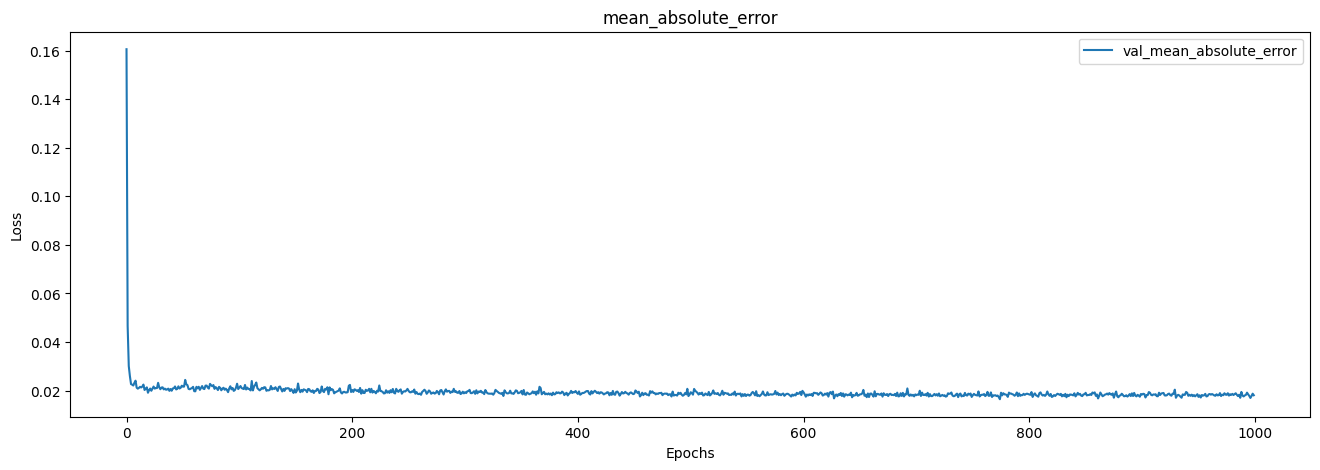

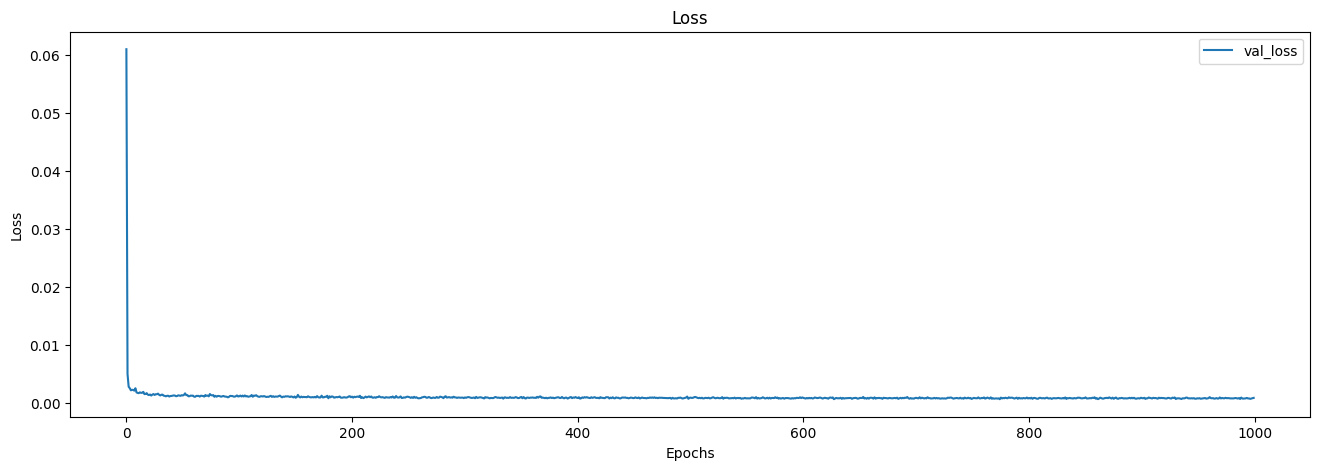

In [13]:
visualize_training_results(history)


In [14]:
# Evaluate the model on the test set
mse, mae = model.evaluate(X_test, y_test)


12/12 [==============================] - 3s 6ms/step - loss: 1.4902e-04 - mean_absolute_error: 0.0096


## Evaluat For Train

In [15]:
y_train_pred = model.predict(X_train)

print('y_train_pred', y_train_pred.shape)
print('y_test', y_train.shape)


# evaluat
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))

print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

45/45 [==============================] - 4s 7ms/step
y_train_pred (1423, 1)
y_test (1423, 1)
RMSE: 0.0095
MSE: 0.0001
MAE:0.0068


In [16]:
from sklearn.metrics import confusion_matrix
bins = np.linspace(0, 1, num=11)

# discretize y_test into categories
y_train_cat = np.digitize(y_train, bins) - 1  # subtract 1 to make categories start from 0

# convert probabilities to binary labels using a threshold
y_pred_prob = y_train_pred.copy()
y_pred_binary = np.where(y_pred_prob >= 0.5, 1, 0)



# calculate confusion matrix
cm = confusion_matrix(y_train_cat, y_pred_binary)

print(cm)


[[933   0   0   0   0   0   0   0   0   0   0]
 [120   0   0   0   0   0   0   0   0   0   0]
 [ 34   0   0   0   0   0   0   0   0   0   0]
 [ 65   0   0   0   0   0   0   0   0   0   0]
 [ 59   5   0   0   0   0   0   0   0   0   0]
 [  0  37   0   0   0   0   0   0   0   0   0]
 [  0  46   0   0   0   0   0   0   0   0   0]
 [  0  47   0   0   0   0   0   0   0   0   0]
 [  0  54   0   0   0   0   0   0   0   0   0]
 [  0  22   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0]]


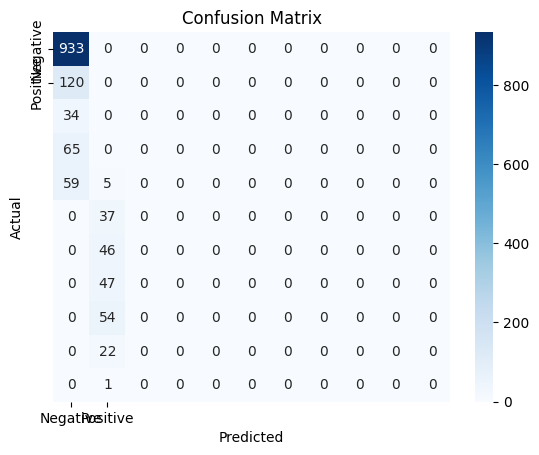

In [17]:
import seaborn as sns
# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Set tick positions and labels
tick_positions = [0.5, 1.5]
tick_labels = ['Negative', 'Positive']
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# Show the plot
plt.show()


In [18]:
class_names = ["negative", "positive"]


# convert y_test and y_pred to binary
y_train_binary = y_train.copy()
y_train_binary[y_train_binary != class_names.index("positive")] = 0
y_train_binary[y_train_binary == class_names.index("positive")] = 1

y_pred_prob = y_train_pred.copy()
y_pred_binary = np.where(y_pred_prob >= 0.5, 1, 0)

# calculate confusion matrix
cm = confusion_matrix(y_train_binary, y_pred_binary)

# calculate TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()

print("True Negative (TN):", tn)
print("False Positive (FP):", fp)
print("False Negative (FN):", fn)
print("True Positive (TP):", tp)
print("Total samples:", len(y_train_binary))


True Negative (TN): 1211
False Positive (FP): 211
False Negative (FN): 0
True Positive (TP): 1
Total samples: 1423


In [19]:

Accuracy = (tp + tn) / (tp + tn + fp + fn)
recall  = tp / (tp + fn)
Specificity = tn / (tn + fp)
Precision = tp / (tp + fp)
f1 = 2 * (Precision * recall) / (Precision + recall)

print("Accuracy: ", round((Accuracy* 100),2))

print("Recall :",round ((recall * 100 ),2 ))

print("Specificity :",round ((Specificity * 100 ),2 ))

print ("Precision:", round((Precision * 100),2))

print('F-Score:', round((f1 * 100),2))




Accuracy:  85.17
Recall : 100.0
Specificity : 85.16
Precision: 0.47
F-Score: 0.94


# Evaluat For Test

In [20]:
y_test_pred = model.predict(X_test)

print('y_test_pred', y_test_pred.shape)
print('y_test', y_test.shape)


# evaluat
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)

rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

12/12 [==============================] - 0s 7ms/step
y_test_pred (356, 1)
y_test (356, 1)
RMSE: 0.0122
MSE: 0.0001
MAE:0.0096


In [21]:
from sklearn.metrics import confusion_matrix
bins = np.linspace(0, 1, num=11)

# discretize y_test into categories
y_test_cat = np.digitize(y_test, bins) - 1  # subtract 1 to make categories start from 0

# convert probabilities to binary labels using a threshold
y_pred_prob1 = y_test_pred.copy()
y_pred_binary1 = np.where(y_pred_prob1>= 0.5, 1, 0)



# calculate confusion matrix
cm_test = confusion_matrix(y_test_cat, y_pred_binary1)

print(cm_test)


[[67  0  0  0  0  0  0  0  0  0  0]
 [67  0  0  0  0  0  0  0  0  0  0]
 [59  0  0  0  0  0  0  0  0  0  0]
 [33  0  0  0  0  0  0  0  0  0  0]
 [ 8  1  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]]


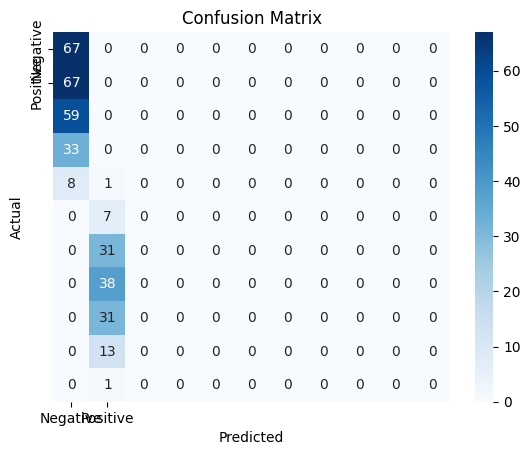

In [22]:

# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap using seaborn
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g')

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Set tick positions and labels
tick_positions = [0.5, 1.5]
tick_labels = ['Negative', 'Positive']
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# Show the plot
plt.show()


In [23]:
cclass_names = ["negative", "positive"]


# convert y_test and y_pred to binary
y_test_binary = y_test.copy()
y_test_binary[y_test_binary != class_names.index("positive")] = 0
y_test_binary[y_test_binary == class_names.index("positive")] = 1

y_pred_prob1 = y_test_pred.copy()
y_pred_binary1 = np.where(y_pred_prob1 >= 0.5, 1, 0)

# calculate confusion matrix
cm_test = confusion_matrix(y_test_binary, y_pred_binary1)

# calculate TN, FP, FN, TP
tn_t, fp_t, fn_t, tp_t = cm_test.ravel()

print("True Negative (TN):", tn_t)
print("False Positive (FP):", fp_t)
print("False Negative (FN):", fn_t)
print("True Positive (TP):", tp_t)
print("Total samples:", len(y_test_binary))


True Negative (TN): 234
False Positive (FP): 121
False Negative (FN): 0
True Positive (TP): 1
Total samples: 356


In [24]:
Accuracy = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
recall  = tp_t / (tp_t + fn_t)
Specificity = tn_t / (tn_t + fp_t)
Precision = tp_t / (tp_t + fp_t)
f1 = 2 * (Precision * recall) / (Precision + recall)

print("Accuracy: ", round((Accuracy* 100),2))

print("Recall :",round ((recall * 100 ),2 ))

print("Specificity :",round ((Specificity * 100 ),2 ))

print ("Precision:", round((Precision * 100),2))

print('F-Score:', round((f1 * 100),2))




Accuracy:  66.01
Recall : 100.0
Specificity : 65.92
Precision: 0.82
F-Score: 1.63


In [25]:


# Step 8: Testing the model
y_pred = model.predict(X_test)
print('y_pred', y_pred.shape)
print('y_test', y_test.shape)


# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


12/12 [==============================] - 0s 7ms/step
y_pred (356, 1)
y_test (356, 1)
RMSE: 0.0122
MSE: 0.0001
MAE:0.0096


In [26]:
# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test= scaler.inverse_transform(y_test)

y_train_pred = scaler.inverse_transform(y_train_pred)
y_train= scaler.inverse_transform(y_train)

In [27]:
# evaluat
mape_test = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
mape_train = 100 * np.mean(np.abs((y_train - y_train_pred) / y_train))
print("MAPE fot Test: {:.4f}%".format(mape_test))
print("MAPE for Train: {:.4f}%".format(mape_train))


MAPE fot Test: 1.3186%
MAPE for Train: 1.0970%


In [21]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days ي
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')
test_dates = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)







In [22]:

y_test_df.to_csv("y_test_ETH_Case1.csv")
y_test_df

,Adj Close
Date,
2022-01-09,3157.751465
2022-01-10,3083.097900
2022-01-11,3238.111572
2022-01-12,3372.258301
2022-01-13,3248.288574
...,...
2022-12-26,1226.974365
2022-12-27,1212.791626
2022-12-28,1189.986084


In [23]:
y_pred_df.to_csv("y_pred_ETH_Case1.csv")  
y_pred_df


,Adj Close
Date,
2022-01-09,3152.276123
2022-01-10,3067.855713
2022-01-11,3207.946533
2022-01-12,3312.620117
2022-01-13,3244.548340
...,...
2022-12-26,1191.531860
2022-12-27,1179.547363
2022-12-28,1159.128296


In [25]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters', title= 'Predictions For ETH Case1')
fig.show()


In [26]:

# Step 1: Data cleaning

data_new = yf.download(tickers='ETH-USD', period='max', interval='1d')
data_new.dropna(inplace=True)
data_new


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2023-04-22,1849.286499,1886.781616,1845.849243,1874.228638,1874.228638,6970642726
2023-04-23,1874.171509,1882.229736,1838.992432,1862.062012,1862.062012,6607451862
2023-04-24,1862.085327,1888.193726,1811.792114,1842.757446,1842.757446,8438191338


In [27]:
# Step 2: Feature engineering
data_new['RSI']       = ta.rsi(data_new.Close, length=15)
data_new['EMA_short'] = ta.ema(data_new.Close, length=20)
data_new['EMA_long']  = ta.ema(data_new.Close, length=100)
data_new.dropna(inplace=True)
data_new.reset_index(inplace=True)
#data_new.drop(['Close'], axis=1, inplace=True)
# Setting the index
data_new.set_index('Date', inplace=True)

# Dropping any NaNs
data_new.dropna(inplace=True)

data_new.info()
data_new.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1896 entries, 2018-02-16 to 2023-04-26
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1896 non-null   float64
 1   High       1896 non-null   float64
 2   Low        1896 non-null   float64
 3   Close      1896 non-null   float64
 4   Adj Close  1896 non-null   float64
 5   Volume     1896 non-null   int64  
 6   RSI        1896 non-null   float64
 7   EMA_short  1896 non-null   float64
 8   EMA_long   1896 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 148.1 KB


,Open,High,Low,Close,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,,
2023-04-17,2120.001221,2120.113525,2063.038574,2076.242920,2076.242920,9648882546,68.181906,1931.625797,1687.702320
2023-04-18,2075.855225,2121.531494,2057.653809,2104.537354,2104.537354,9134015143,69.795408,1948.093564,1695.956479
2023-04-19,2103.946289,2104.857178,1928.582886,1936.403442,1936.403442,13779745451,52.761030,1946.980219,1700.717805
2023-04-20,1936.417969,1979.573364,1918.132812,1943.097656,1943.097656,11324135406,53.247784,1946.610451,1705.517406
2023-04-21,1943.409912,1955.649170,1827.788940,1849.999878,1849.999878,12044274581,46.160467,1937.409444,1708.378445
2023-04-22,1849.286499,1886.781616,1845.849243,1874.228638,1874.228638,6970642726,48.087150,1931.392225,1711.662607
2023-04-23,1874.171509,1882.229736,1838.992432,1862.062012,1862.062012,6607451862,47.178790,1924.789347,1714.640813
2023-04-24,1862.085327,1888.193726,1811.792114,1842.757446,1842.757446,8438191338,45.710873,1916.976785,1717.177776
2023-04-25,1842.204346,1877.484985,1805.322876,1866.753662,1866.753662,8677255481,47.871004,1912.193631,1720.139675


In [29]:
future_data = data_new.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Close","Adj Close", "Volume", "RSI",
                                                 "EMA_short", "EMA_long"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today, periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 8)
y_future_data: (30, 1)
x_future_data: (30, 8)
future_data_temp (30, 8)
future_data_temp (29, 8)
future_data_temp (28, 8)
future_data_temp (27, 8)
future_data_temp (26, 8)
future_data_temp (25, 8)
future_data_temp (24, 8)
future_data_temp (23, 8)
future_data_temp (22, 8)
future_data_temp (21, 8)


In [30]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 8)
1/1 [==============================] - 0s 66ms/step
future_data_temp2 (30, 1, 8)
---------------------------------------------------
future_data_temp1 (29, 8)
1/1 [==============================] - 0s 46ms/step
future_data_temp2 (29, 1, 8)
---------------------------------------------------
future_data_temp1 (28, 8)
1/1 [==============================] - 0s 94ms/step
future_data_temp2 (28, 1, 8)
---------------------------------------------------
future_data_temp1 (27, 8)
1/1 [==============================] - 0s 72ms/step
future_data_temp2 (27, 1, 8)
---------------------------------------------------
future_data_temp1 (26, 8)
1/1 [==============================] - 0s 57ms/step
future_data_temp2 (26, 1, 8)
---------------------------------------------------
future_data_temp1 (25, 8)
1/1 [==============================] - 0s 44ms/step
future_data_temp2 (25, 1, 8)
---------------------------------------------------
future_data_temp1 (24, 8)
1/1 [===============

In [31]:
prediction_df


,Adj Close
2023-04-26,1772.667579
2023-04-27,1796.261807
2023-04-28,1794.490380
2023-04-29,1821.695660
2023-04-30,1816.055640
2023-05-01,1796.814984
2023-05-02,1813.679425
2023-05-03,1872.477500
2023-05-04,1910.410525
2023-05-05,1877.849068


In [32]:
y_future_data


,Adj Close
Date,
2023-03-28,1772.785645
2023-03-29,1793.001831
2023-03-30,1792.737183
2023-03-31,1822.022095
2023-04-01,1813.860596
2023-04-02,1795.708130
2023-04-03,1810.297119
2023-04-04,1871.005127
2023-04-05,1909.114014


In [33]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))

fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=y_future_data.index[-1], y1=y_future_data['Adj Close'][-1],
              line=dict(color='grey', width=2))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [34]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.add_shape(type='line',
              x0=actual_x[-1], y0=actual_y[-1],
              x1=pred_x[0], y1=pred_y[0],
              line=dict(color='grey', width=2, dash='dot'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


In [35]:
future_data_all = data_new.copy()

future_data_all = pd.DataFrame(future_data_all, index= future_data_all.index, 
                               columns=future_data_all.columns)

x_future_data_all = future_data_all.drop(['Adj Close'], axis=1).values
y_future_data_all = future_data_all['Adj Close'].values
y_future_data_all = y_future_data_all.reshape(-1, 1)

print("x_future_data:", x_future_data_all.shape)
print("y_future_data:", y_future_data_all.shape)


x_future_data: (1896, 8)
y_future_data: (1896, 1)


In [36]:
x_future_data_all = scaler.fit_transform(x_future_data_all)
y_future_data_all = scaler.fit_transform(y_future_data_all)

x_future_data_all = np.reshape(x_future_data_all, (x_future_data_all.shape[0], 1, x_future_data_all.shape[1]))

pred_future_all = model.predict(x_future_data_all)


60/60 [==============================] - 0s 6ms/step


In [37]:

y_future_data_all = scaler.inverse_transform(y_future_data_all)
pred_future_all = scaler.inverse_transform(pred_future_all)
y_future_all = pd.DataFrame(y_future_data_all, index= future_data_all.index,  columns=['Adj Close'])
pred_future_all_df = pd.DataFrame(pred_future_all, index= future_data_all.index,  columns=['Adj Close'])
print("pred_future_all:", pred_future_all.shape)
print("y_future_data:", y_future_data_all.shape)

pred_future_all: (1896, 1)
y_future_data: (1896, 1)


In [38]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_future_all.index, y=y_future_all['Adj Close'], name='Actual Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=y_future_all.index, y=pred_future_all_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))

fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='gray')))
fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=pred_future_all_df.index[-1], y1=pred_future_all_df['Adj Close'][-1],
              line=dict(color='grey', width=2))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters', title = 'Predictions For ETH Case1 next 10 Days')
fig.show()
